# Ряды. ДЗ №3. Модели ARIMA

In [156]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg,  ar_select_order
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from math import sqrt

In [157]:
# формируем датафрейм - количество продаж за месяц
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
sales_of_company_x["Month"] = pd.to_datetime(sales_of_company_x["Month"])
sales_of_company_x2=sales_of_company_x
sales_of_company_x.set_index('Month', inplace = True)

df = pd.Series(sales_of_company_x["Count"])
df


Month
1965-01-01    154
1965-02-01     96
1965-03-01     73
1965-04-01     49
1965-05-01     36
             ... 
1971-01-01    628
1971-02-01    308
1971-03-01    324
1971-04-01    248
1971-05-01    272
Name: Count, Length: 77, dtype: int64

In [158]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [159]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Определим базовые характерисики ряда и проверим его на условие стационарности

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


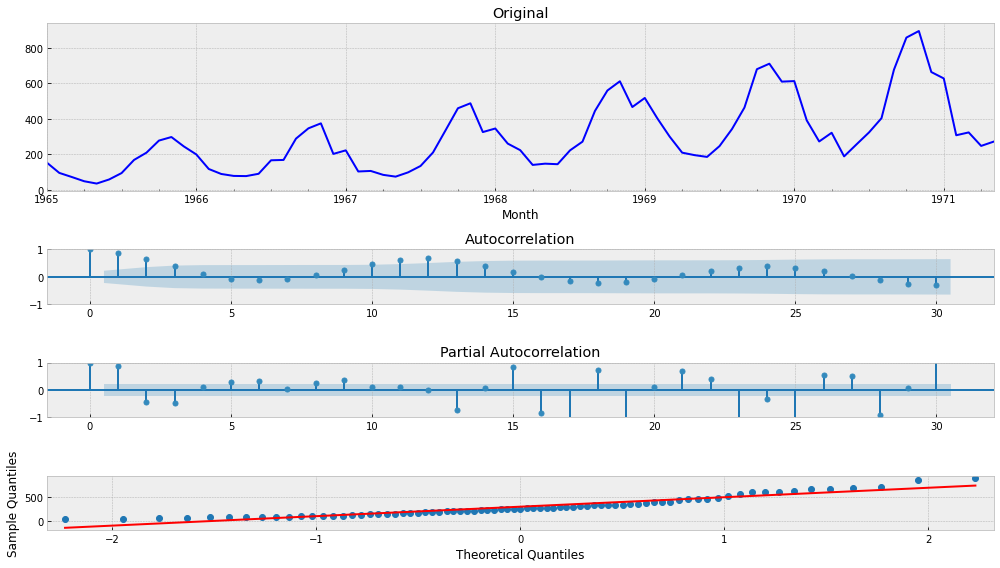

In [160]:
tsplot(df, lags=30)

Приведем ряд к стационарному виду.
Изменение дисперсии скорректируем преобразованием Бокса-Кокса, наличие тренда с помощью диффиренцирования

In [161]:
#ADF-test(differenced-time-series)
df2 = pd.Series(boxcox(df, 0)) # преобразование Бокса-Кокса
df3 = pd.Series(df2.diff())
df4 = sm.tsa.adfuller(df3.dropna(),regression='c')
print('p-value:{}'.format(df4[1]))
# сформируем стационарный ряд (датафрейм)
df3s = pd.DataFrame({"Count": df3})
df3s = df3s.dropna()
df3s.index = df.index[1:]

p-value:0.02402539283987568


Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


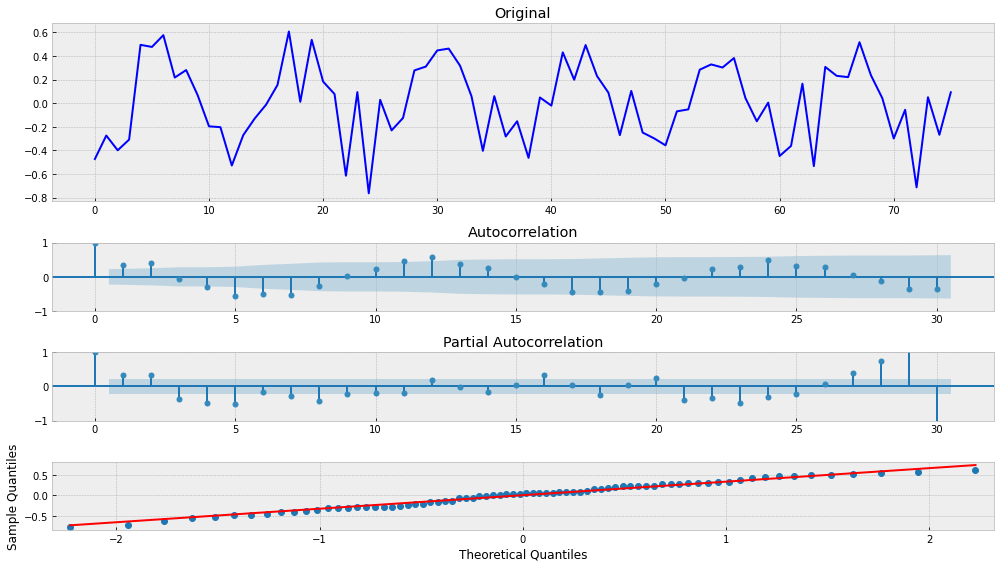

In [162]:
tsplot(np.diff(df2), lags=30)

В итоге получаем стационарный ряд

## Построим прогнозы исходного ряда с помощью нескольких моделей:

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

ARMA предполагает, что в данных отсутствует тренд и сезонность (данные стационарны). 

Если данные нестационарны, нужно использовать более сложные версии этих моделей:

•	ARIMA, здесь добавляется компонент Integrated (I), который отвечает за удаление тренда (сам процесс называется дифференцированием); 

•	SARIMA, эта модель учитывает сезонность (Seasonality, S)

•	SARIMAX включает еще и внешние или экзогенные факторы (eXogenous factors, отсюда и буква X в названии), 
которые напрямую не учитываются моделью, но влияют на нее.


In [163]:
df = pd.Series(sales_of_company_x["Count"])
df.shape[0]

77

In [164]:
# Определим оптимальные параметры AR, MA c помощью моделей ARMA и ARIMA
import warnings
warnings.filterwarnings("ignore")
resDiff = sm.tsa.arma_order_select_ic(df, max_ar=7, max_ma=7, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best choice')

ARMA(p,q) = (6, 5) is the best choice


ARIMA (p,d,q)
 
Многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. 

В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель

In [165]:
import itertools
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA
#df = pd.Series(dowjones_closing["Close"])
df=pd.Series(sales_of_company_x ["Count"])

p = range(0,5)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(df, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

(3, 1, 2) 858.2121934112151


эти параметры дают более высокое значение AIC поэтому в дальнейшем будем использовать их

In [166]:
arma_mod = ARIMA(df, order=best_pdq).fit()
print(arma_mod.params)

ar.L1        1.357971
ar.L2       -0.375270
ar.L3       -0.349689
ma.L1       -1.794245
ma.L2        0.911233
sigma2    3645.368439
dtype: float64


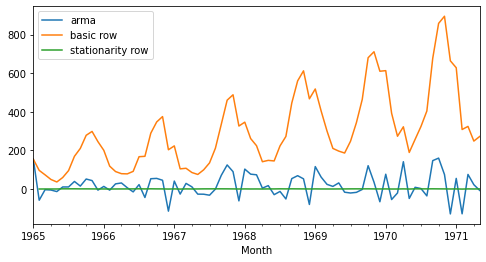

In [167]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
arma_mod.resid.plot(ax=ax, label='arma')
df.plot(label='basic row')
df3s['Count'].plot(label='stationarity row')
plt.legend()
plt.show()


видно, что стацонарный ряд в итоге сглаживает данные исходного (нестационарного) ряда

In [168]:
# построим отчет по выбранным параметрам
model = ARIMA(df, order=(best_pdq)) # p, d и q
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   77
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -423.106
Date:                Wed, 12 Apr 2023   AIC                            858.212
Time:                        19:15:54   BIC                            872.197
Sample:                    01-01-1965   HQIC                           863.801
                         - 05-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3580      0.099     13.651      0.000       1.163       1.553
ar.L2         -0.3753      0.168     -2.230      0.026      -0.705      -0.045
ar.L3         -0.3497      0.099     -3.534      0.0

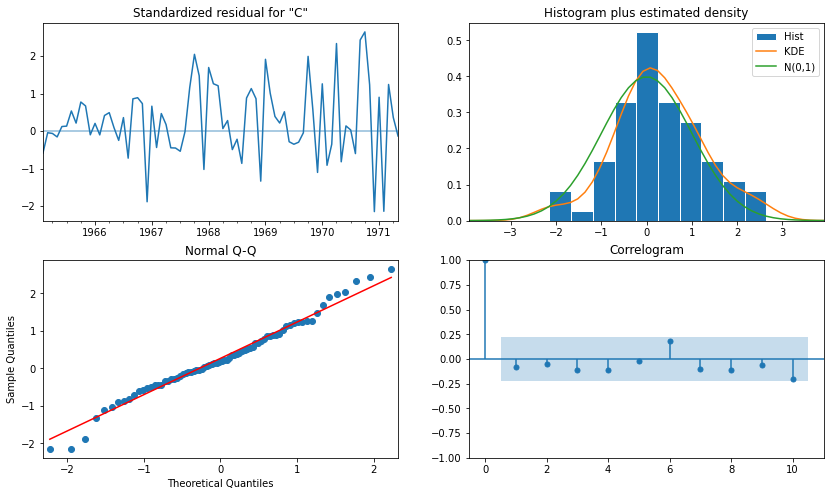

In [169]:
result.plot_diagnostics(figsize=(14, 8))
plt.show()

Все 4 графика показывают, что параметры модели подобраны достаточно точно

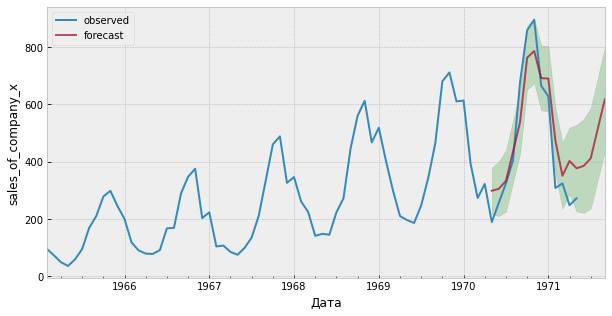

In [181]:
# построим прогноз на основе оптимальных параметров модели ARIMA
with plt.style.context('bmh'):
    pred = result.get_prediction(start=64, end=80, dynamic=False)
    pred_ci = pred.conf_int()

    ax = df[1:].plot(label='observed', figsize=(10, 5))
    pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1], color='g', alpha=.2)
    ax.set_xlabel('Дата')
    ax.set_ylabel('sales_of_company_x')
    plt.legend()
    plt.show()

## Построим модель SARIMAX

In [171]:
df = pd.Series(sales_of_company_x["Count"])
df.shape[0]

77

In [172]:
# обучающая выборка будет включать данные до декабря 1959 года включительно
train = df[:64]
# тестовая выборка начнется с января 1960 года (по сути, один год)
test = df[64:]

In [173]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)
 
# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)
# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
# создадим объект этой модели
model = SARIMAX(train, 
                order = (3, 1, 2), 
                seasonal_order = (0, 1, 0, 12))
 
# применим метод fit
result = model.fit()

In [174]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
# и закончится в конце тестового
end = len(train) + len(test) - 1
# применим метод predict
pred = result.predict(start, end)
#pred

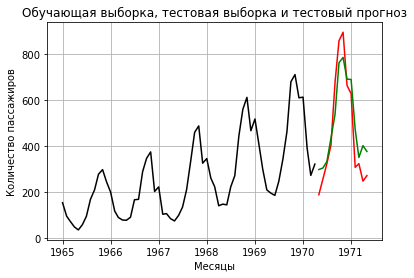

In [175]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(pred, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')
 
plt.grid()
plt.show()

In [176]:
# найдем % точности модели SARIMAX
actual = df[64:]
mape = 100-np.mean(np.abs((actual - pred)/actual))*100
mape

76.37547228106492

In [177]:
# разoбьем весь датасет на тренировочную и тестовую выборку и найдем метрики качества
def prepareData(data, lag_start=1, lag_end=12, test_size=0.15):
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Month"], axis=1)  
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    #print(data)
    return X_train, X_test, y_train, y_test
    

In [178]:
X_train, X_test, y_train, y_test = prepareData(data, lag_start=1, lag_end=12, test_size=0.3)

In [179]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  
from sklearn.inspection import permutation_importance
models = []
models.append(('LR', LinearRegression(),'b'))
models.append(('Ridge', Ridge(),'r'))
models.append(('NN', MLPRegressor(solver = 'lbfgs',max_iter=7000),'c'))  
models.append(('KNN', KNeighborsRegressor(),'m')) 
models.append(('RF', RandomForestRegressor(n_estimators = 100),'y'))
models.append(('SVR', SVR(gamma='auto',kernel = 'linear'),'k'))

LR: R2 - 0.861884, mse - 7675
Ridge: R2 - 0.861885, mse - 7675
NN: R2 - 0.812713, mse - 10407
KNN: R2 - 0.639275, mse - 20044
RF: R2 - 0.734267, mse - 14766
SVR: R2 - 0.829122, mse - 9495


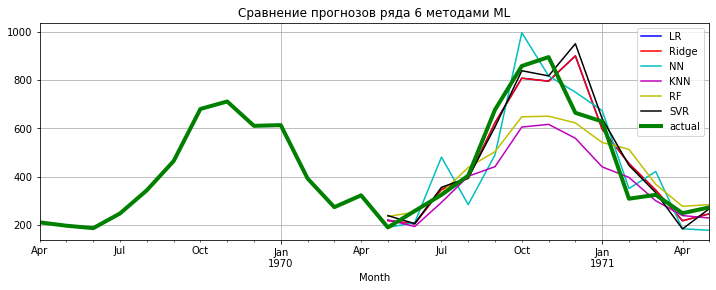

In [180]:
df2= sales_of_company_x
plt.figure(figsize=(12, 4))
for name, model, clr in models:
    model.fit(X_train, y_train)
    r2 = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    df3 = df2.copy()[-13:] # прогноз на год
    df3['y_pred']= y_pred
    print('%s: R2 - %f, mse - %.0f' % (name, r2, mse))
    #plt.plot(df3['y_pred'],label=name,color=clr)
    df3['y_pred']["1970-01-01":].plot(figsize=(12,4),label=name,color=clr)
df2['Count']["1969-04-01":].plot(figsize=(12,4),label='actual',color='g', linewidth=4.0)

plt.grid(True);
plt.legend()
plt.title('Сравнение прогнозов ряда 6 методами ML')
plt.show()

Результат довольно высокий по всем моделям несмотря на небольшое количество данных (77 значений)

Вывод: К плюсам моделей ARMA можно отнести возможность подбора и выбора оптимальных коэффициентов для прогноза. В тоже время эти модели можно использовать только для стационарных рядов. ARIMA дополнительно позволяет учесть тренд ряда. Модели SARIMAX дают более широкий набор параметров, в том числе для построения прогнозных значений. В то же время это требует поиска методов их оптимизации. 'Классические' модели ML показали более высокие результаты. Это объясняется явно выраженным тредом и сезонностью исходного временного ряда, что позволило подобрать оптимальные features (лаги), но результаты могут оказаться хуже если будет проводиться анализ нестационарных рядов. 